# Background / noise region detection and extraction test
How well is the background detection algo working.

The silent parts are detected by a customized split algo from librosa (librosa.effects.split).
- Where the top_db value is calculated as mean(rms-energy without labeled parts) + 1

Loaded audio tracks from audio/simpleCall
Already processed: audio\simpleCall\B2_C_B_Jt1_16_07_06_042.wav, audio\simpleCall\B2_C_TR_Jt1_16_06_02_018.wav, audio\simpleCall\B2_C_TR_Jt2_16_06_02_044.wav, ... (299 others)


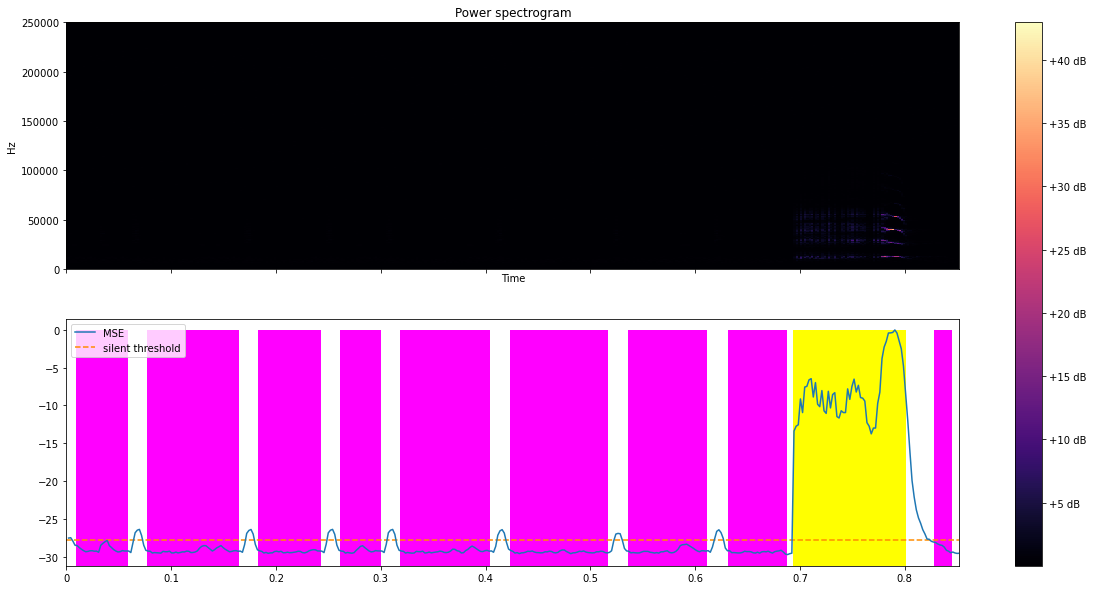

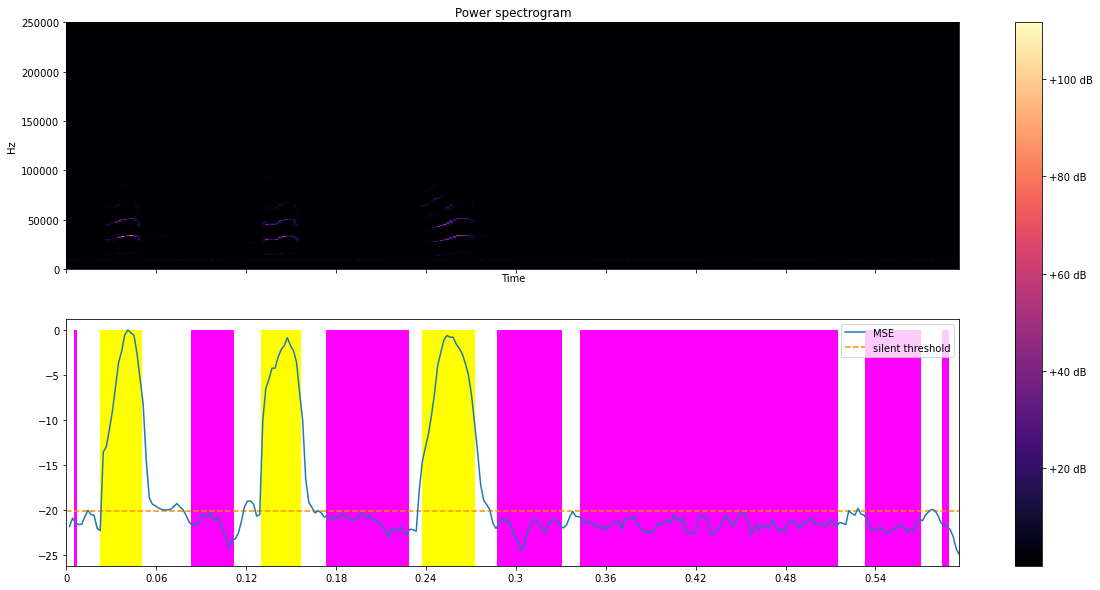

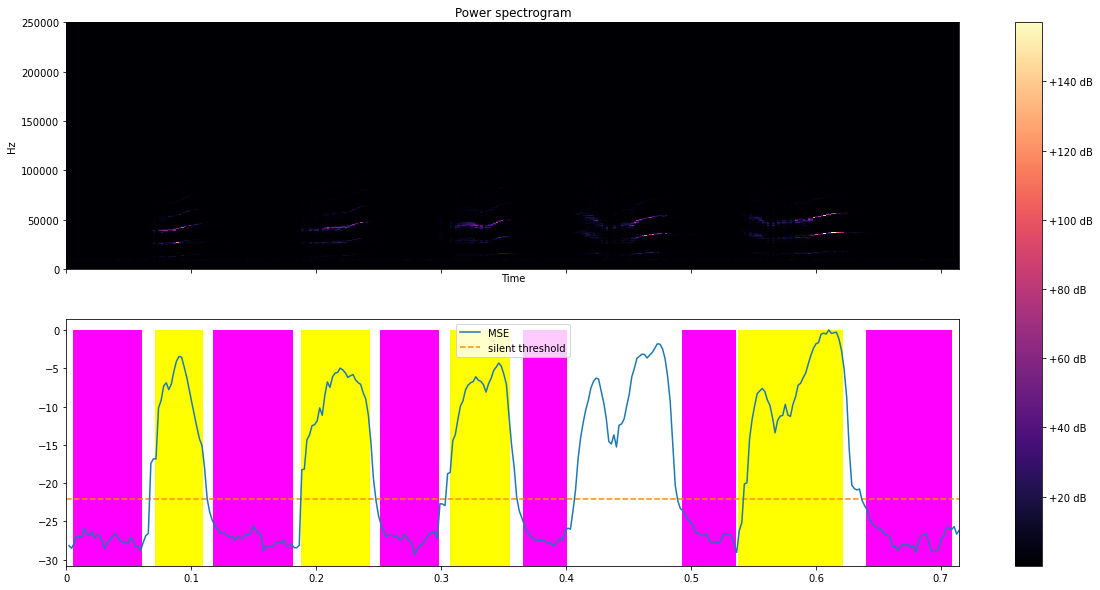

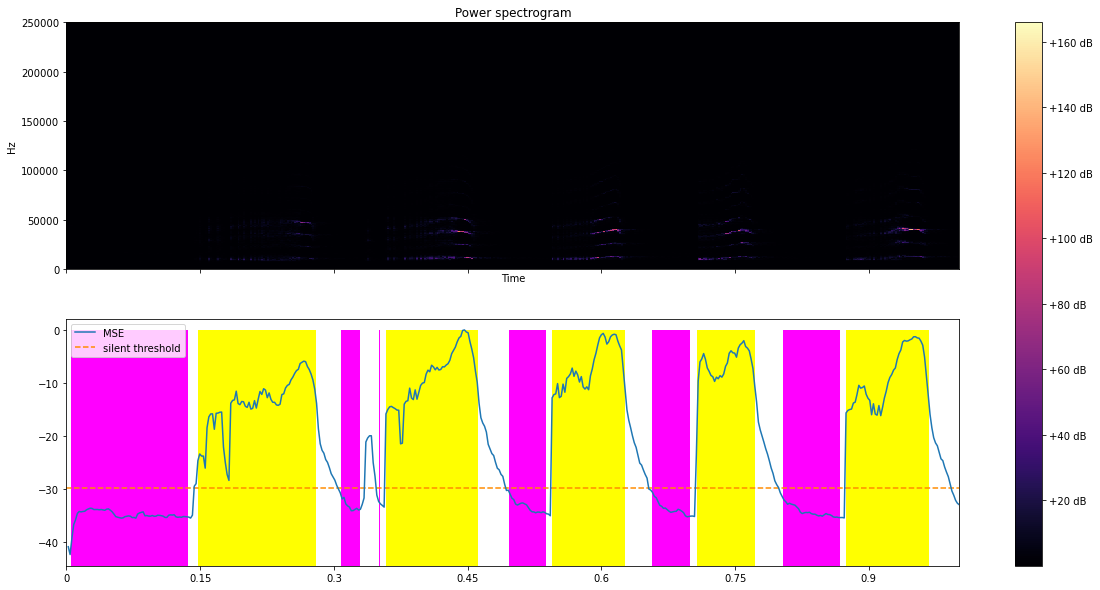

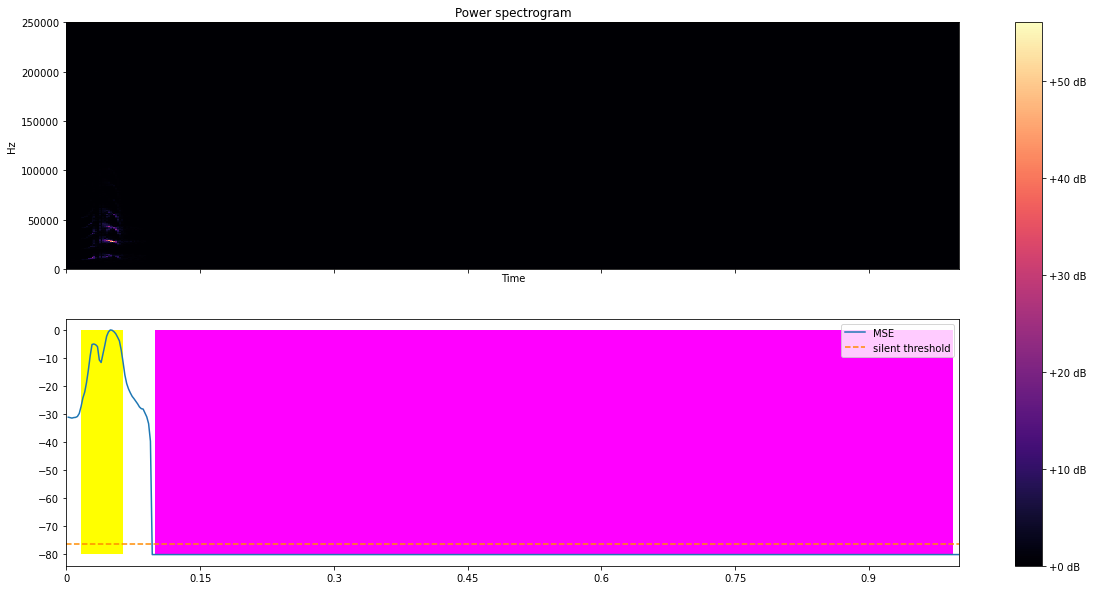

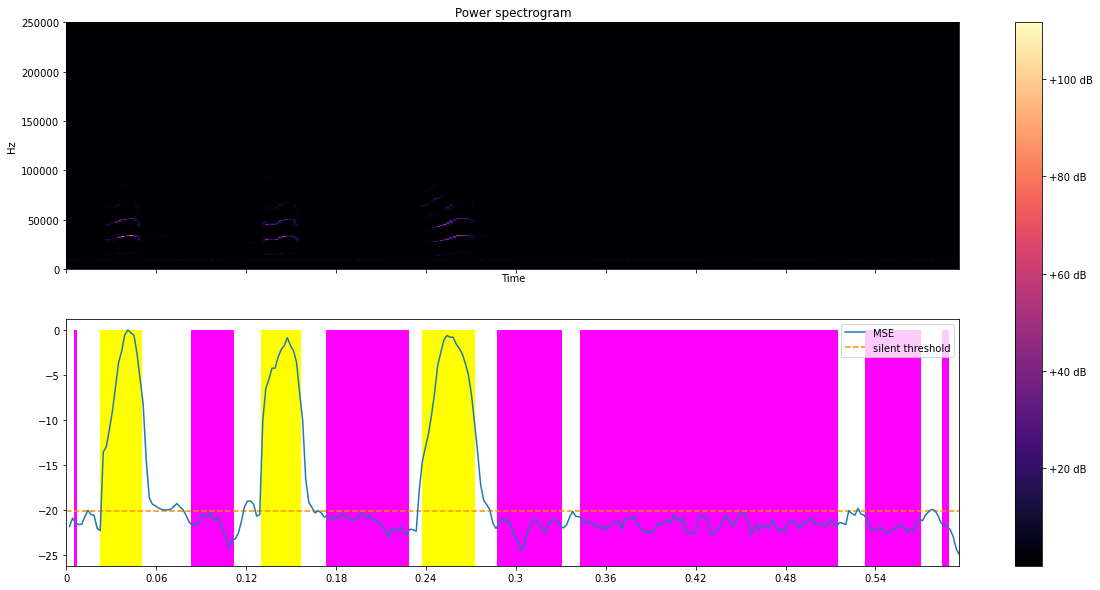

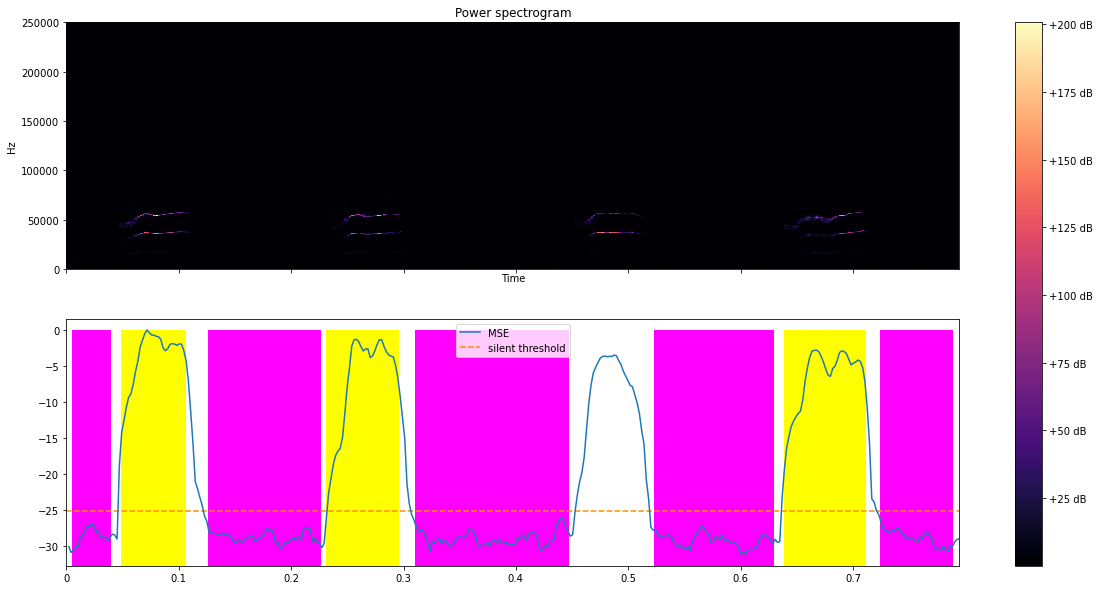

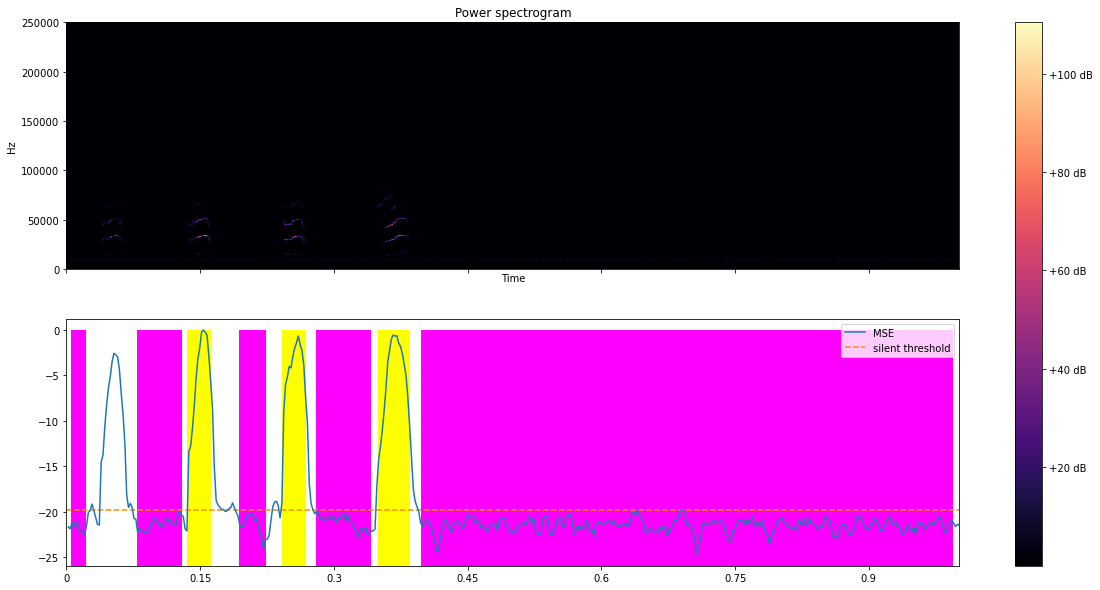

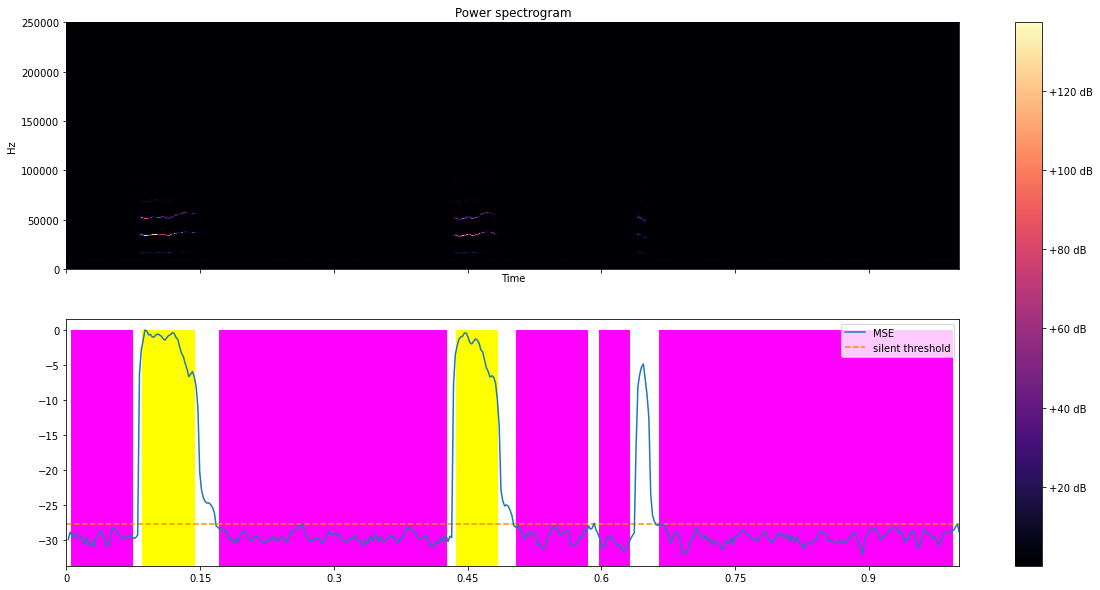

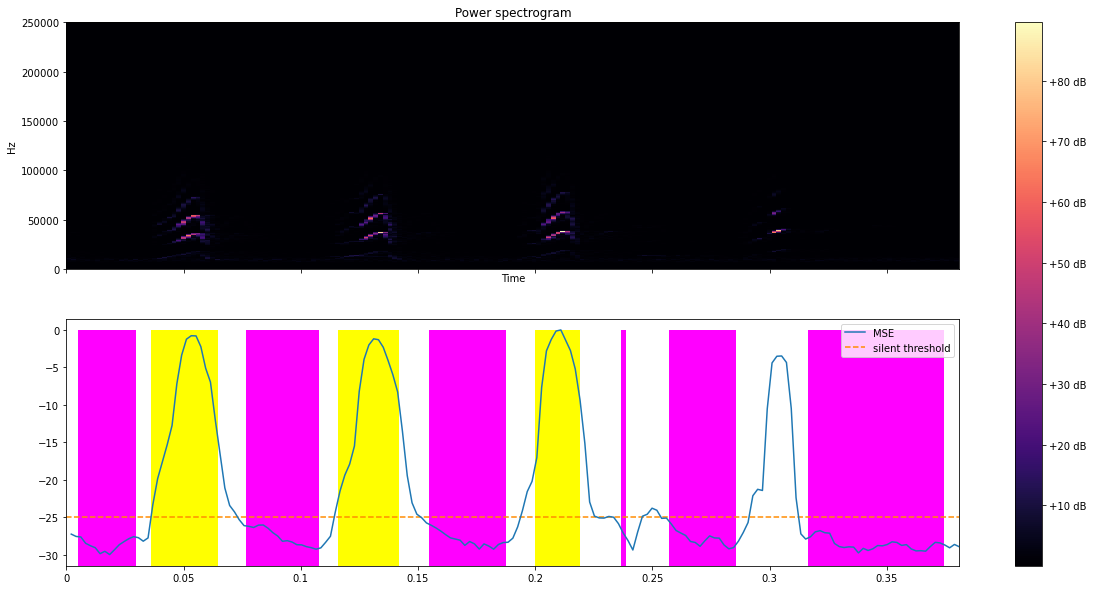

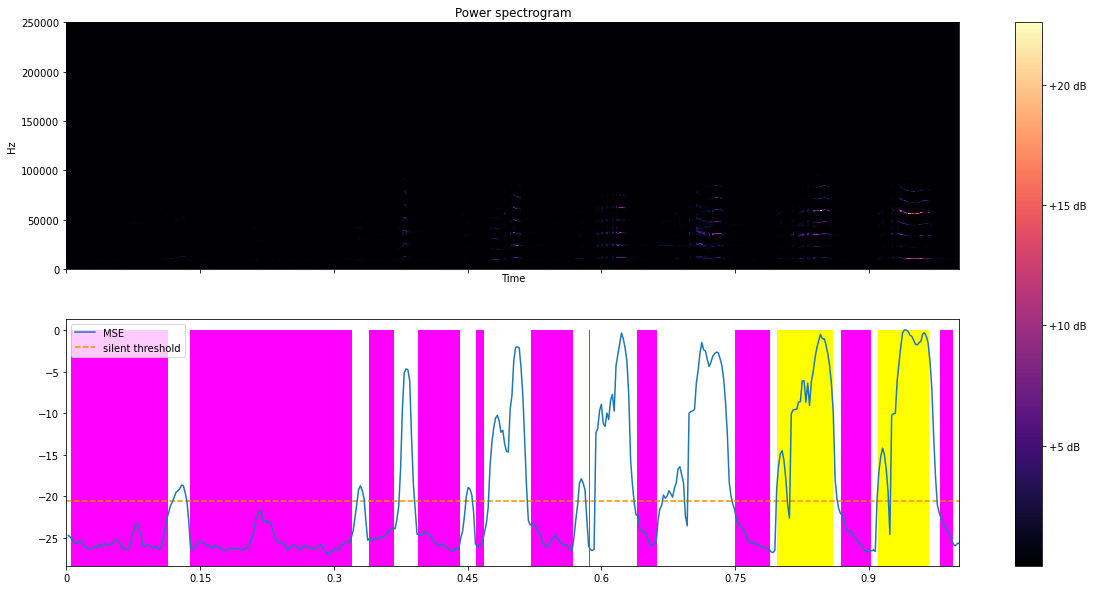

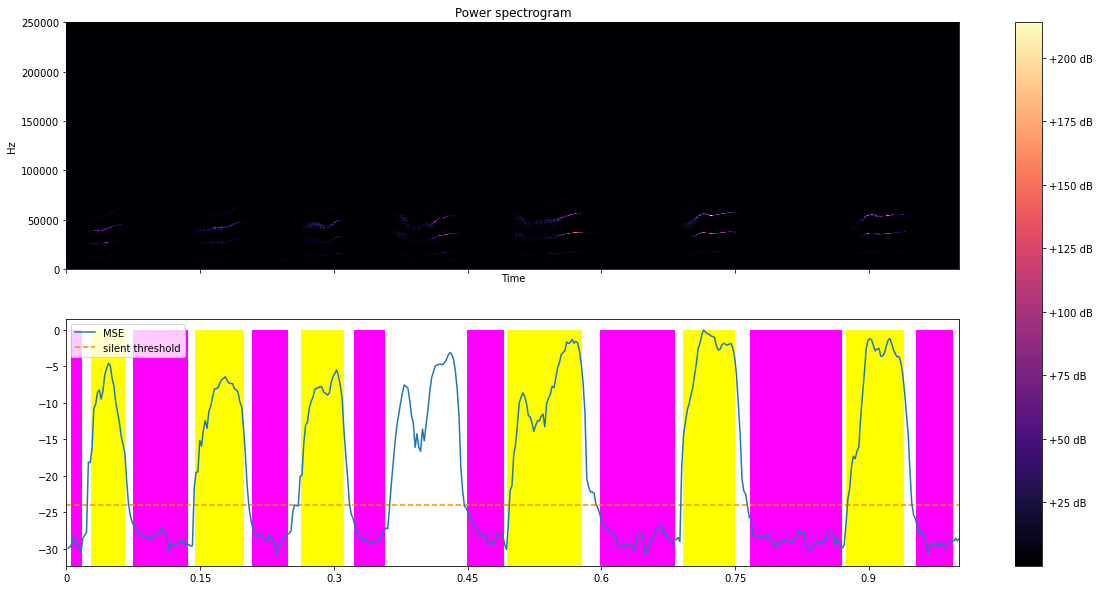

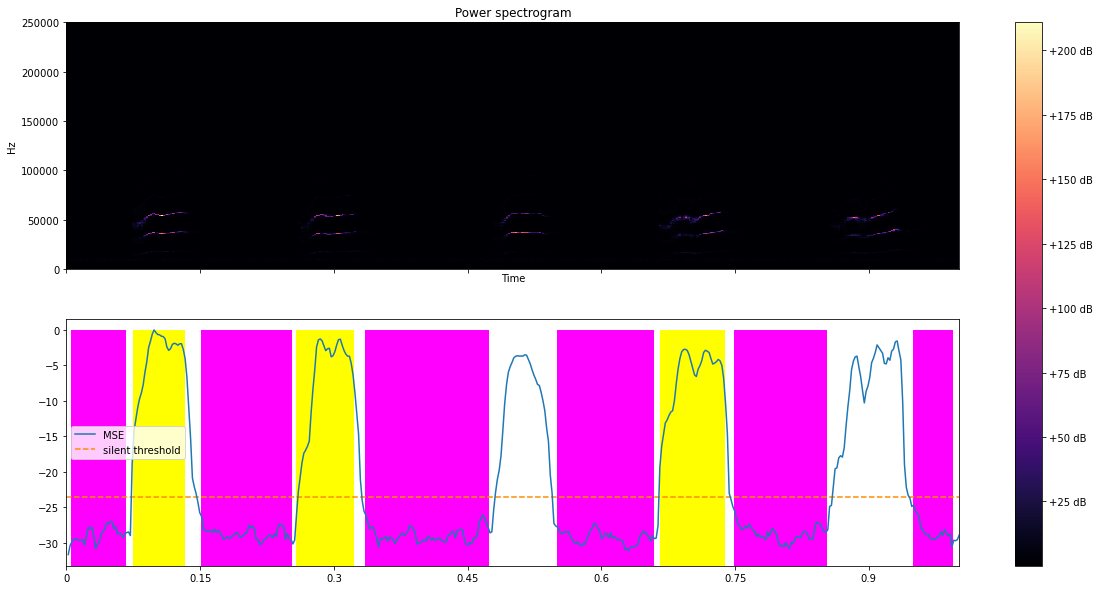

%USERPROFILE%\scoop\apps\miniconda3\current\envs\bat_syllable_Classifier\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=403
  warnings.warn(


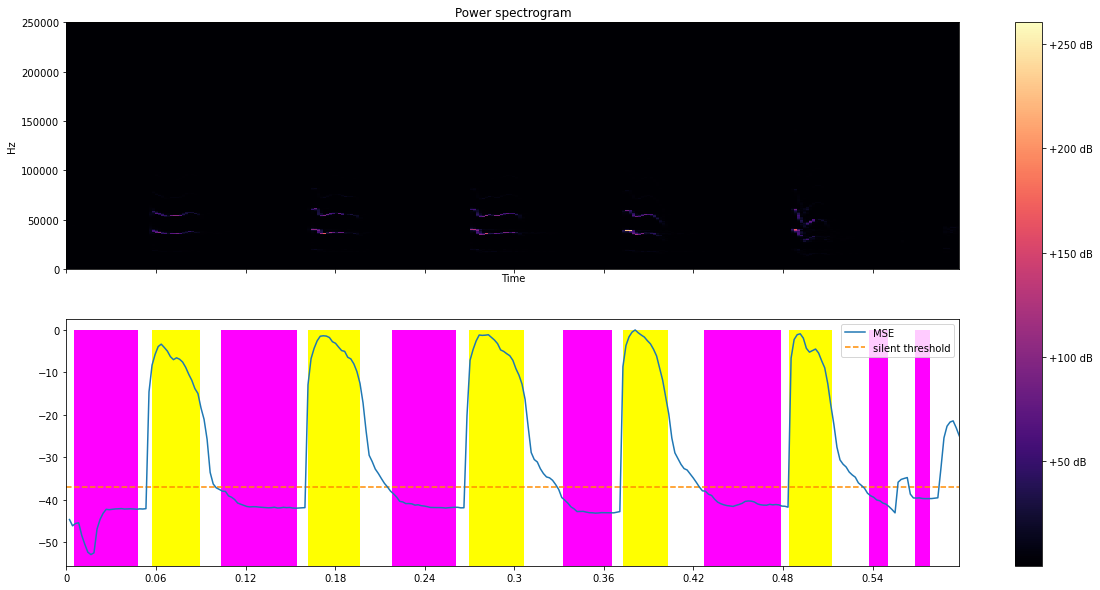

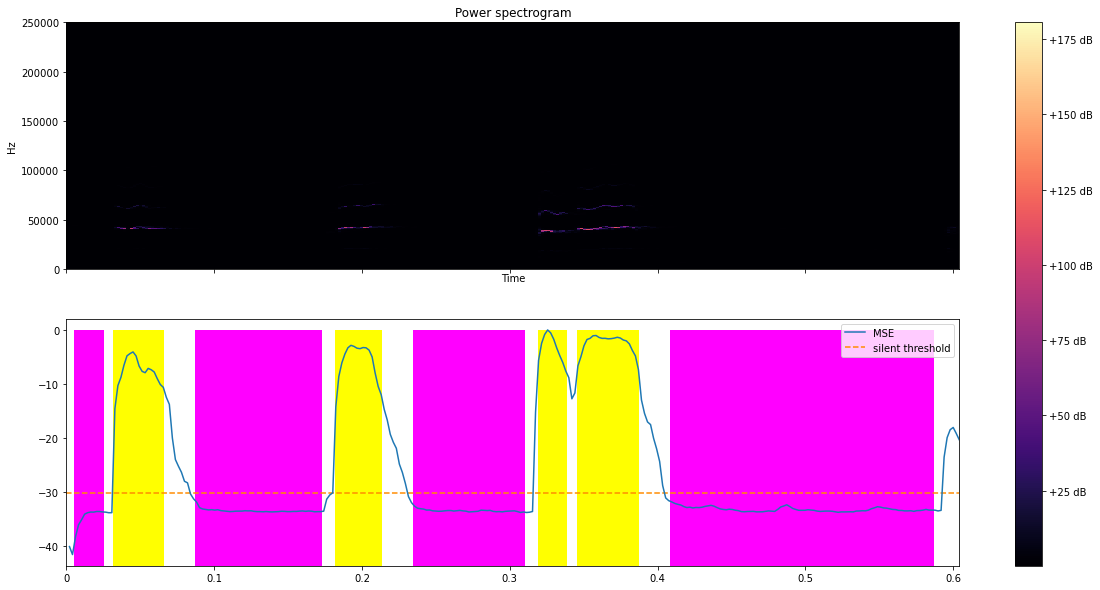

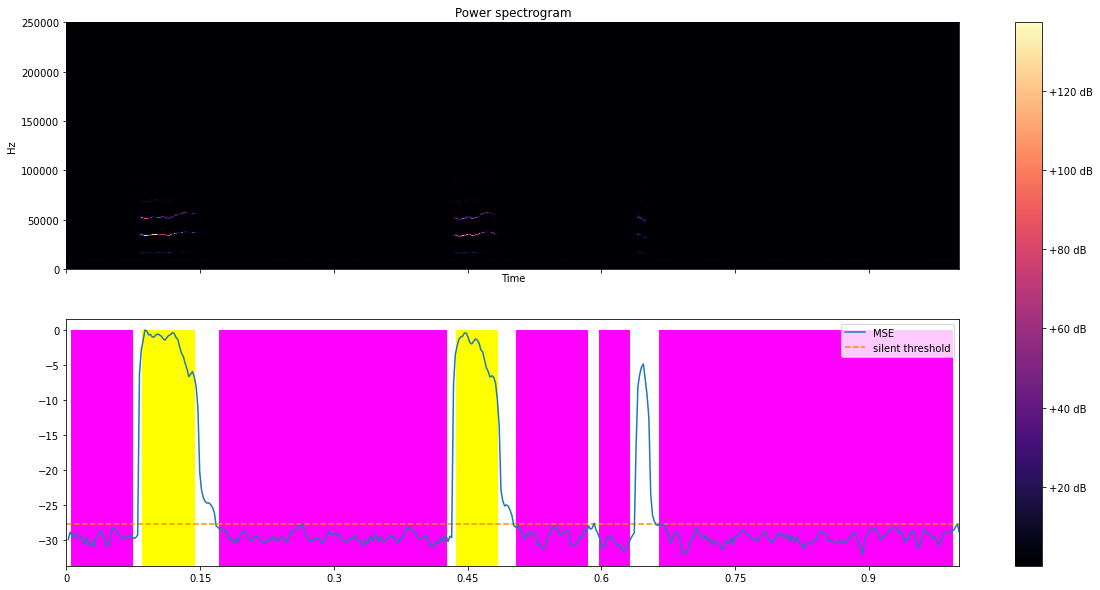

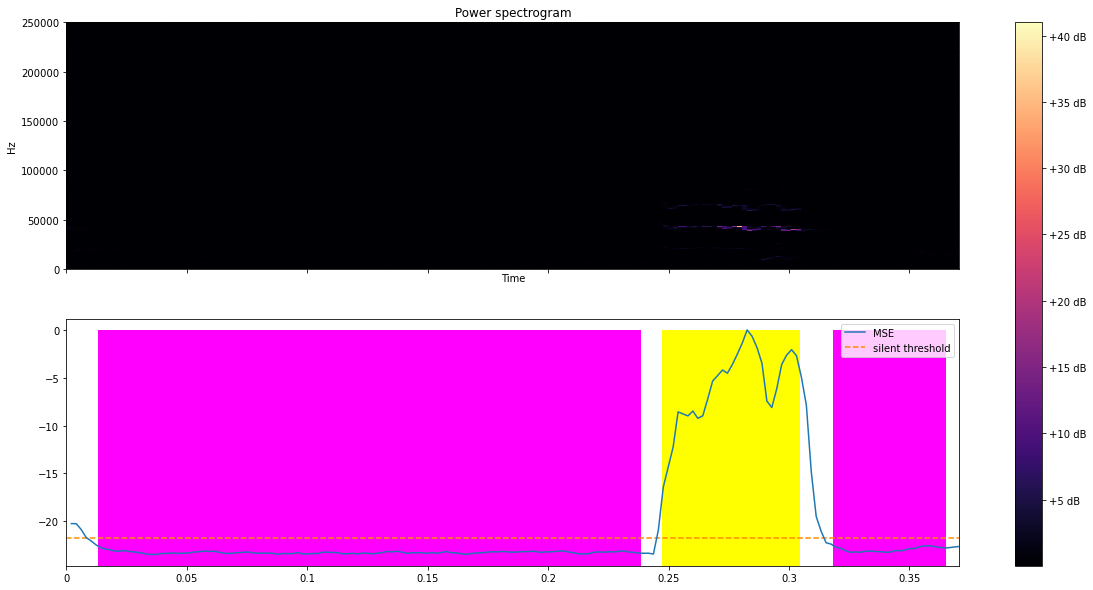

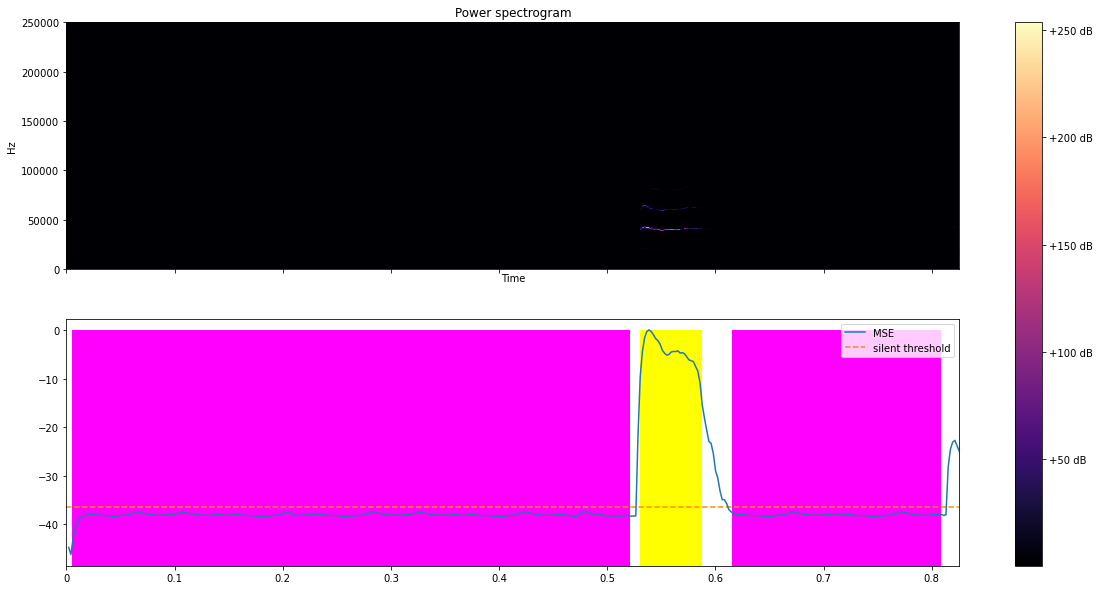

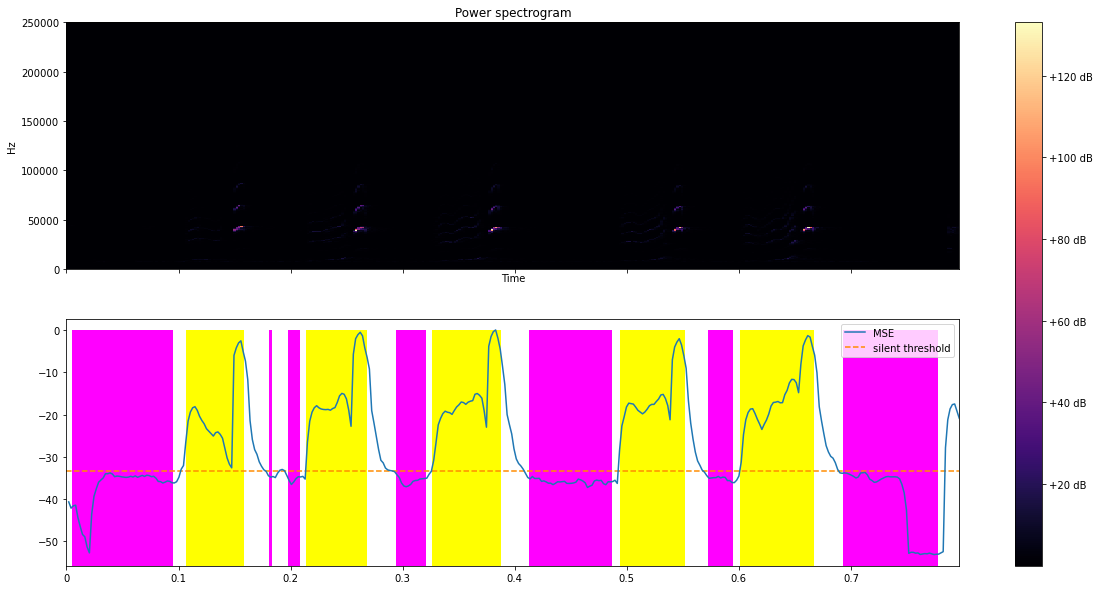

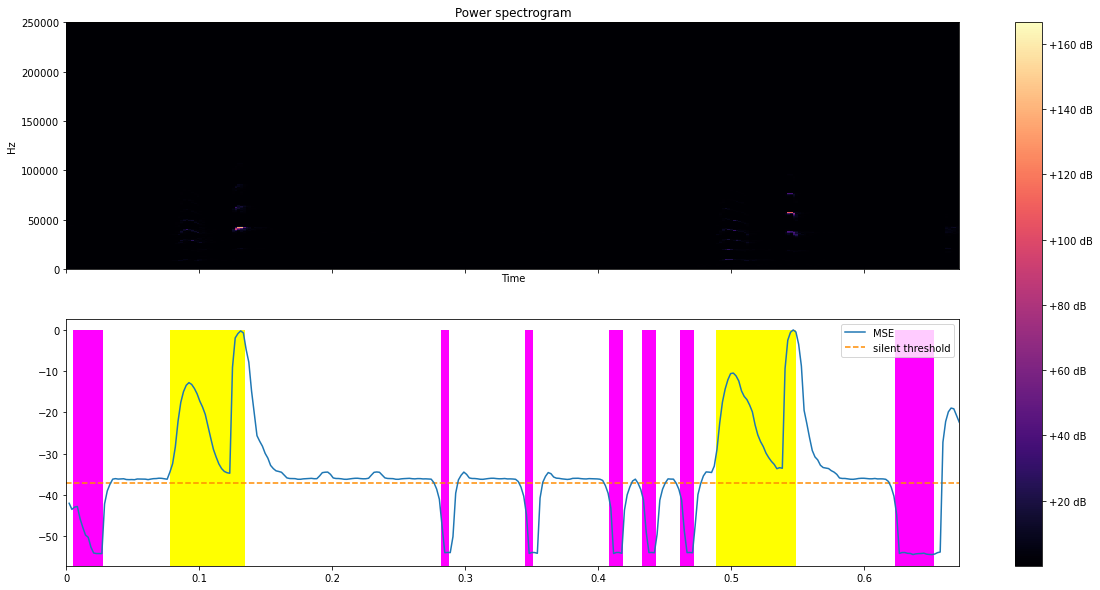

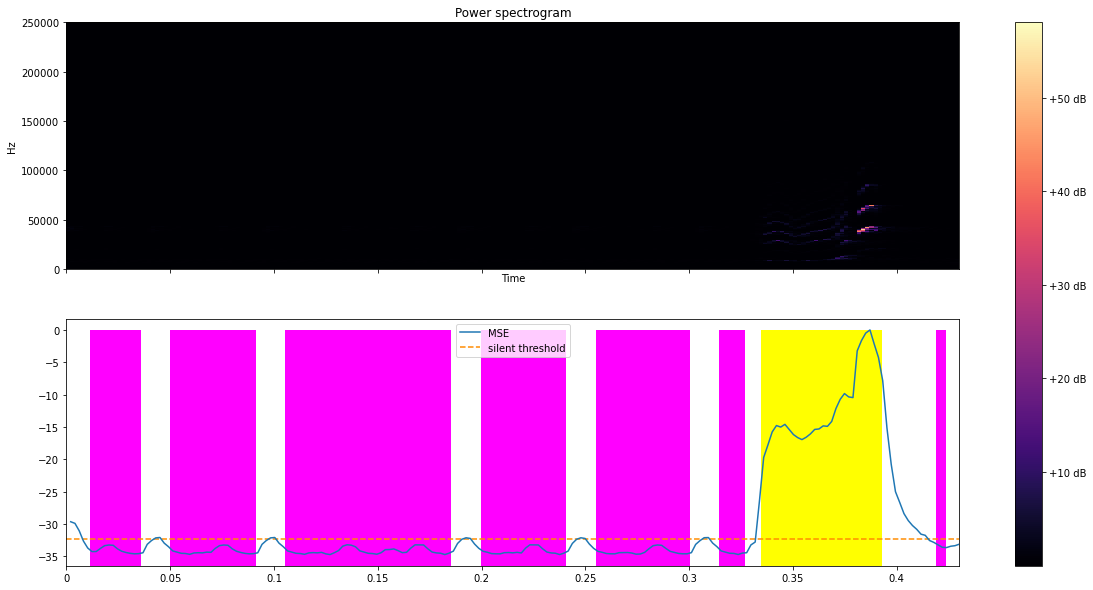

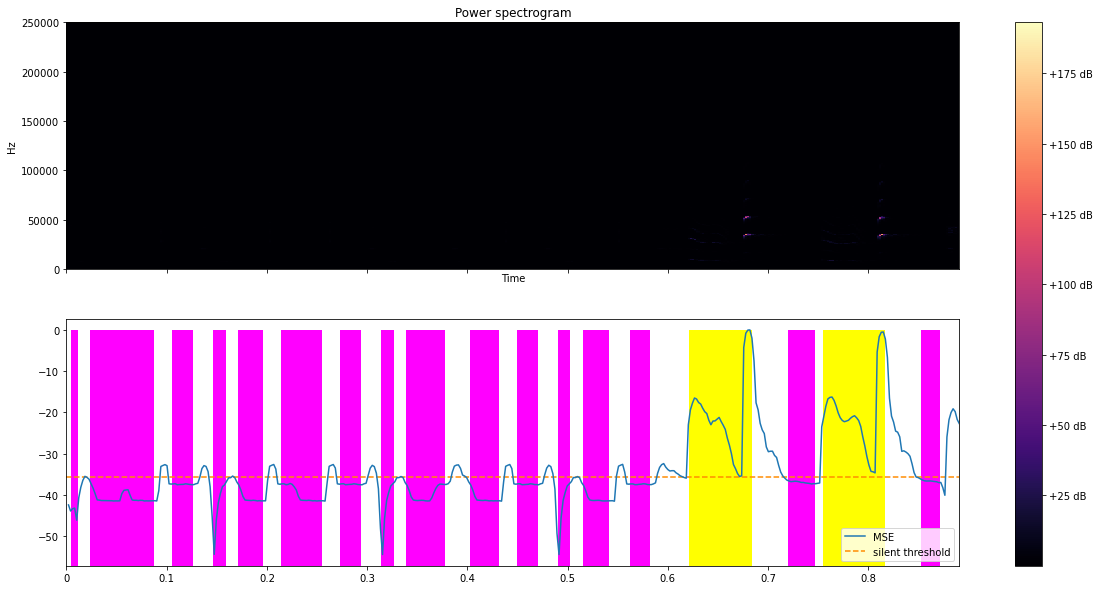

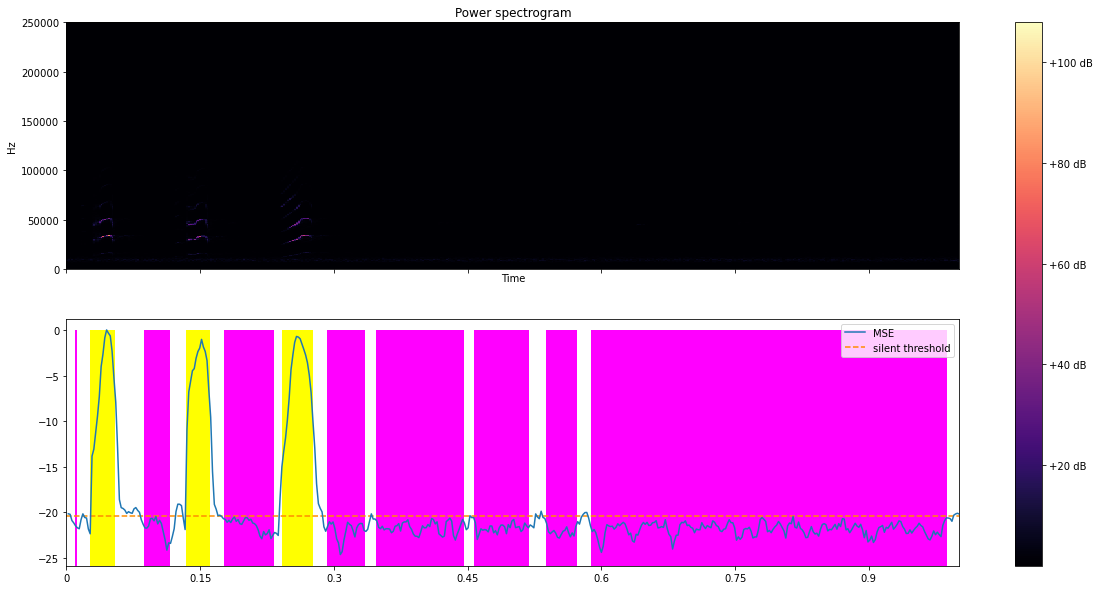

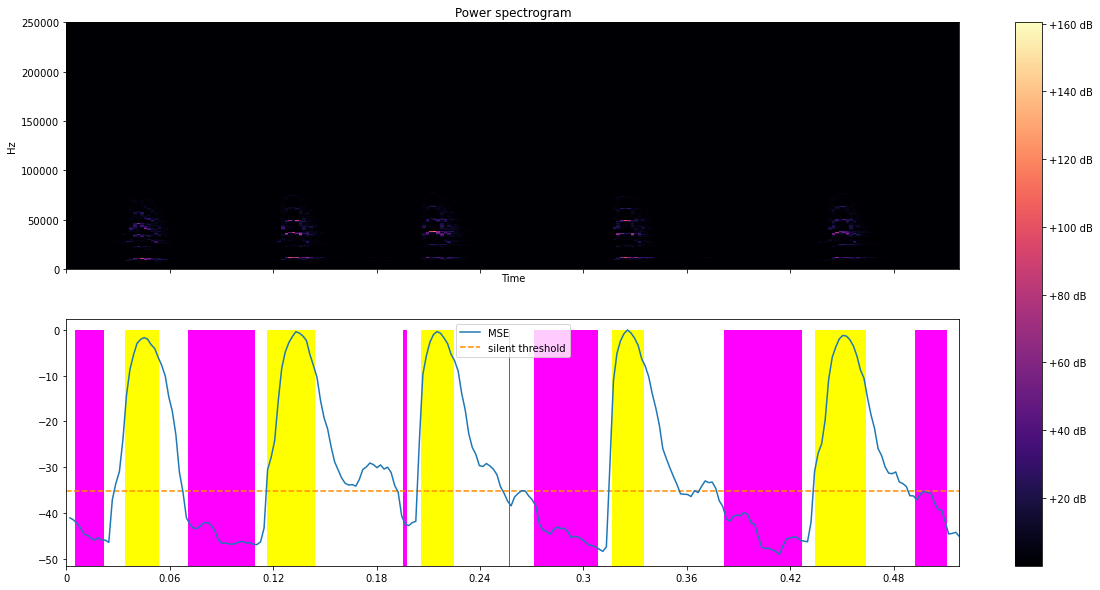

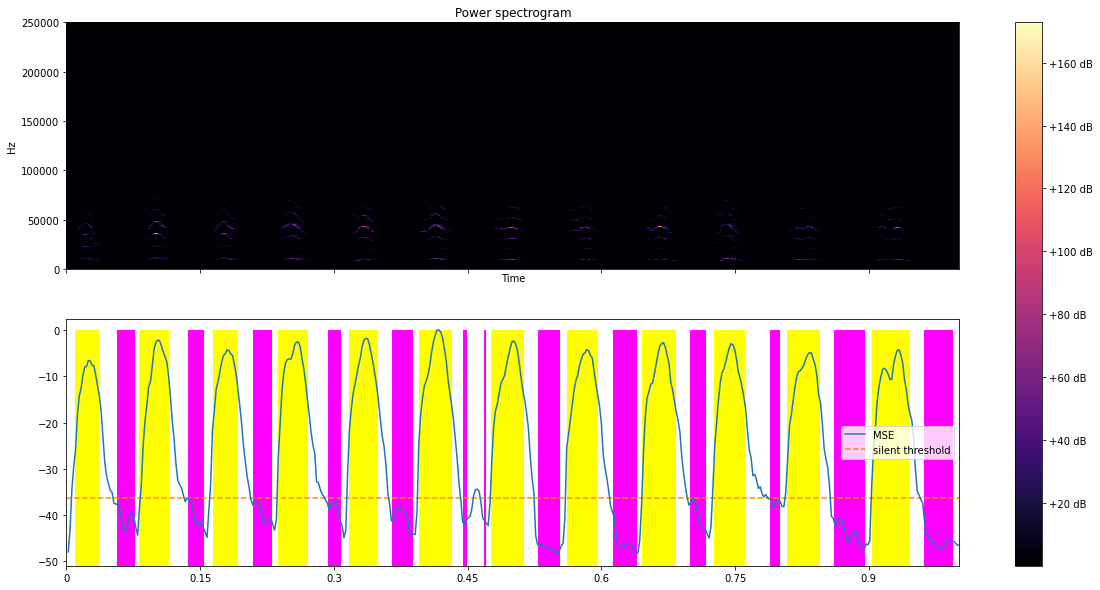

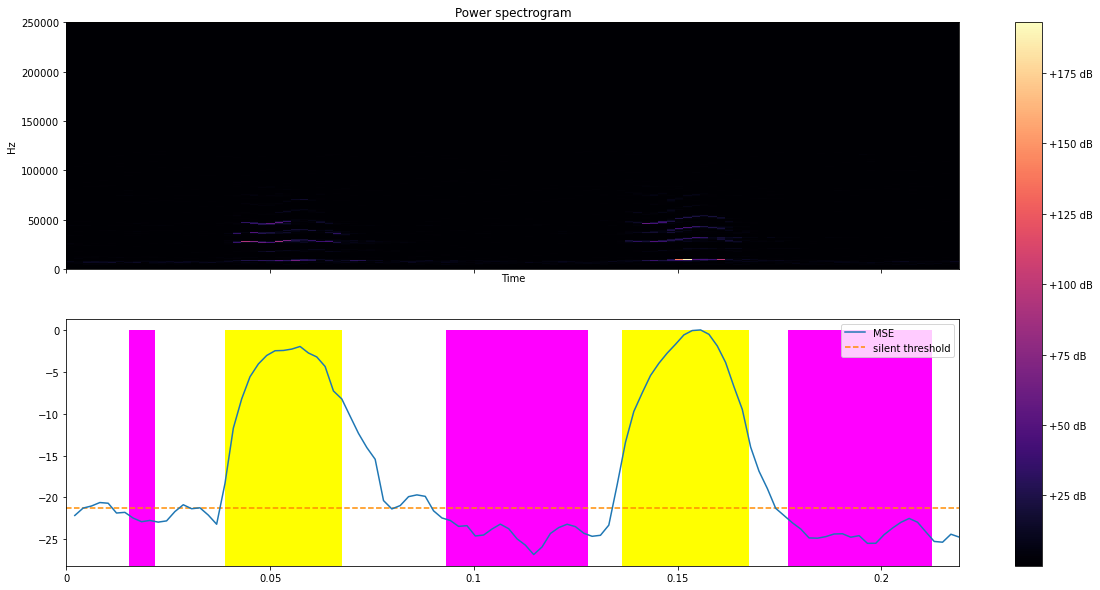

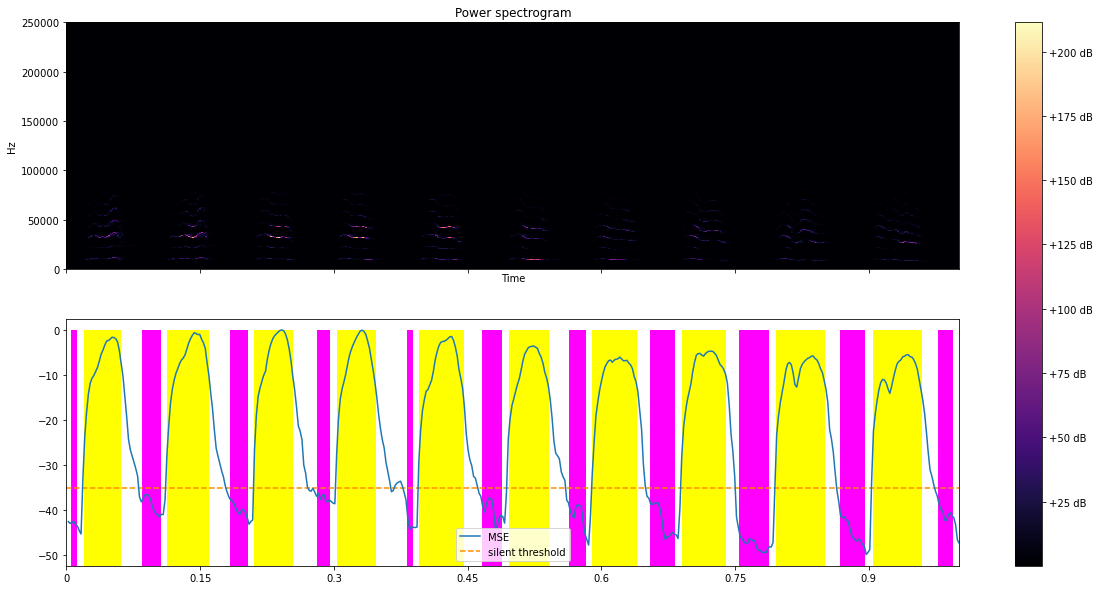

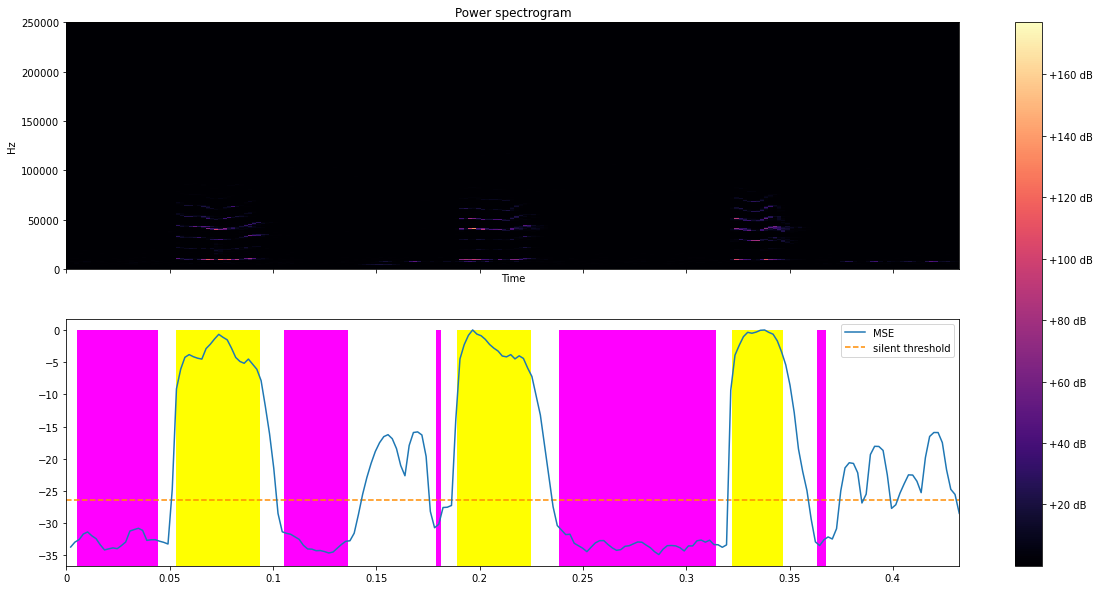

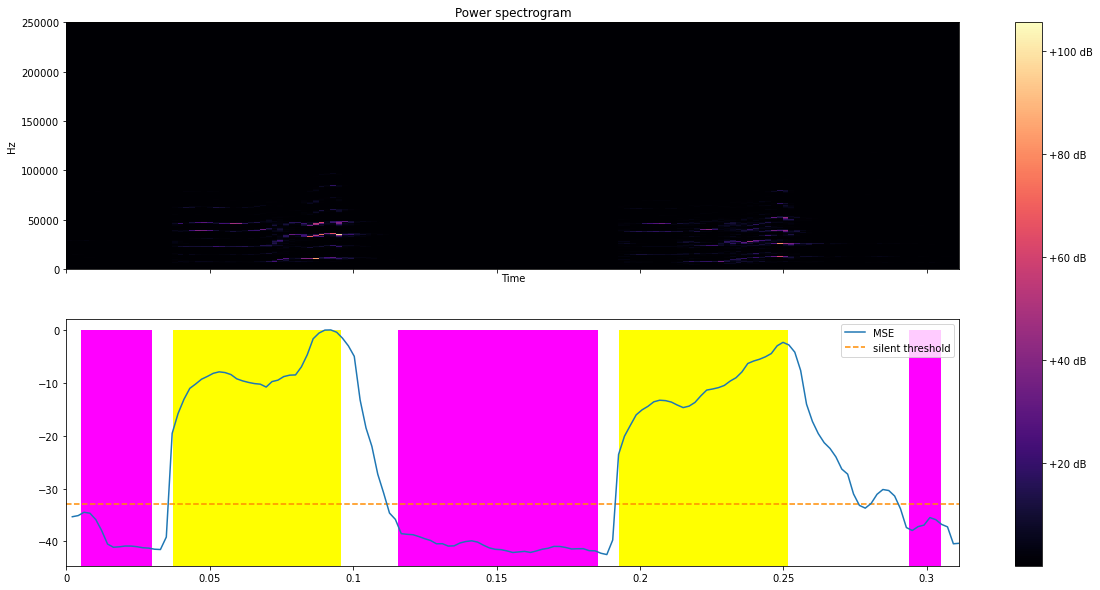

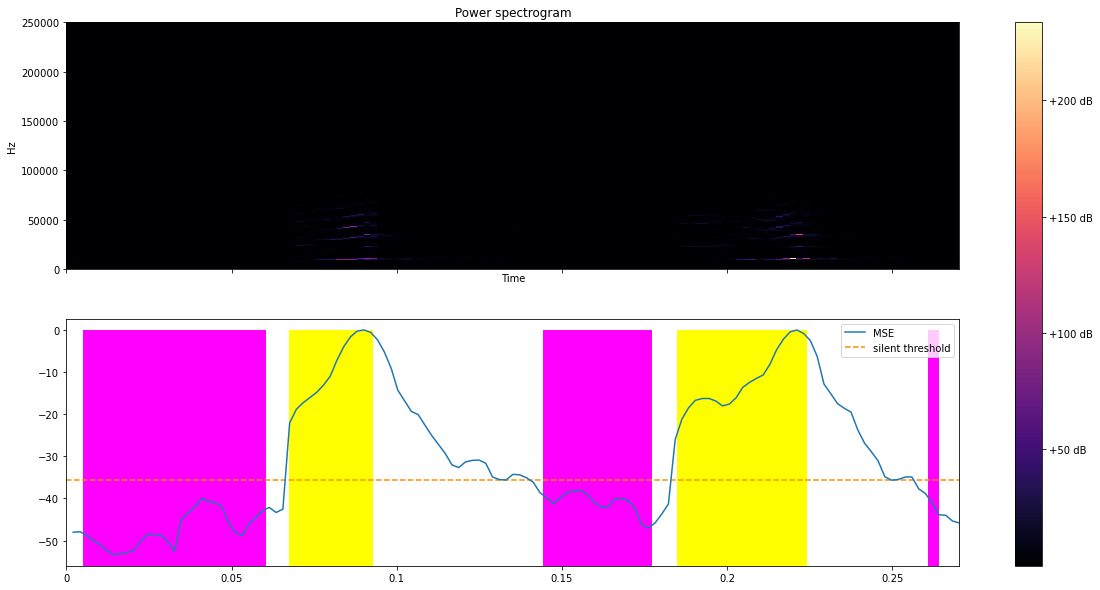

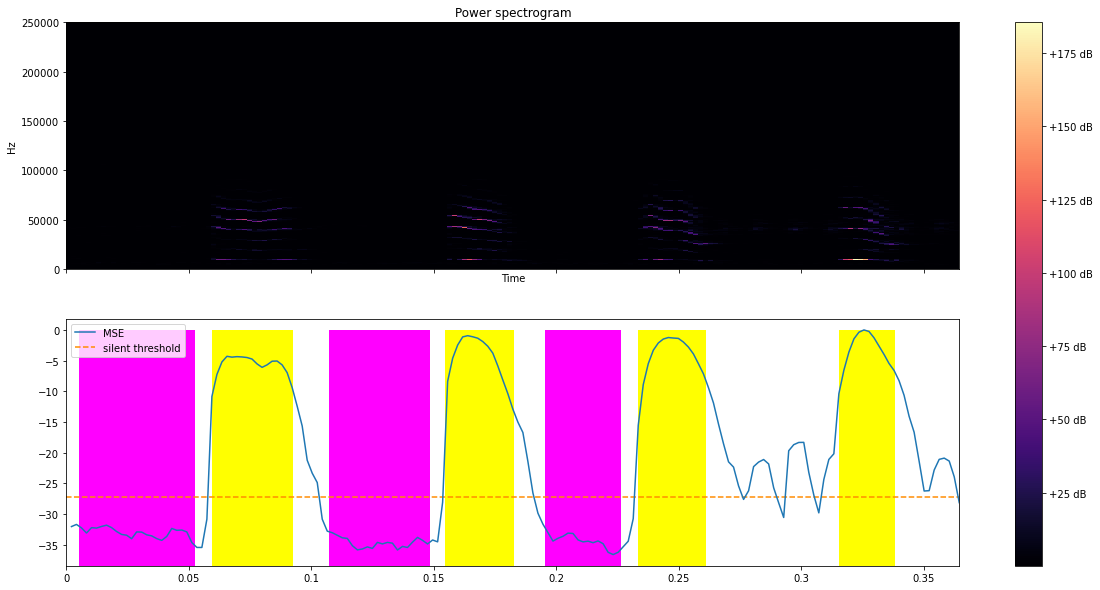

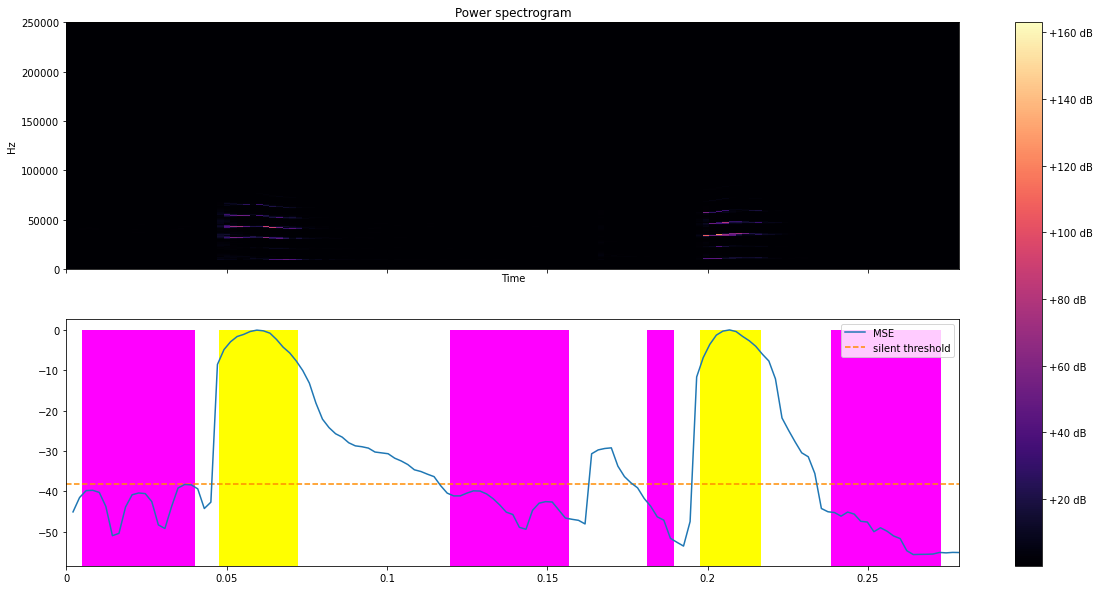

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import librosa
import librosa.display
from engine.metadata import metadata_db
from engine.audio import load_audio
from engine.processing.audio.silent import get_silent_parts, filter_silent_parts, filter_and_transform_labels


n_fft = 2048
hop_length = n_fft//2
fft = {'n_fft': n_fft, 'hop_length': hop_length}

mdb = metadata_db('audio/simpleCall/metadata.json')
files = load_audio(mdb, 'simple_call_test', 'audio/simpleCall').run().files


def specshow(S):
    # plt.figure(figsize=(40, 10))
    fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))
    # specshow_rms(ax[1], silence_time)
    specshow_mse(ax[1], silence_time)

    img = librosa.display.specshow(np.abs(S), y_axis='linear', x_axis='time', ax=ax[0], sr=sr, hop_length=hop_length)
    ax[0].set_title('Power spectrogram')
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    plt.show()

def specshow_rms(ax, non_silence):
    times = librosa.times_like(rms, sr=sr, **fft)
    ax.semilogy(times, rms[0], label='root-mean-square (RMS)')

    for start, end in non_silence:
        rect = patches.Rectangle((start,0), end-start, .6, linewidth=0, edgecolor='r',facecolor='magenta')
        ax.add_patch(rect)

    for start, end in librosa.samples_to_time(labels, sr):
        rect = patches.Rectangle((start,0), end-start, .6, linewidth=0, edgecolor='r',facecolor='yellow')
        ax.add_patch(rect)

    ax.legend()
    ax.label_outer()

def specshow_mse(ax, non_silence):
    times = librosa.times_like(rms, sr=sr, **fft)
    ax.semilogy(times, mse, label='MSE')
    ax.hlines(cut_off, 0, max(times),colors='darkorange',linestyles="dashed", label='silent threshold')
    ax.set_yscale('linear')

    for start, end in non_silence:
        rect = patches.Rectangle((start,0), end-start, -80, linewidth=0, edgecolor='r',facecolor='magenta')
        ax.add_patch(rect)

    for start, end in librosa.samples_to_time(labels, sr):
        rect = patches.Rectangle((start,0), end-start, -80, linewidth=0, edgecolor='r',facecolor='yellow')
        ax.add_patch(rect)

    ax.legend()

i = 0
for file in files:
    y, sr = librosa.load(file.path(), sr=500000, duration=1)
    S = librosa.stft(y, **fft)
    max_db = np.max(np.abs(librosa.amplitude_to_db(np.abs(S), ref=np.max, top_db=None)))

    # rms = librosa.feature.rms(S=S)
    rms = librosa.feature.rms(y=y, frame_length=4096, hop_length=hop_length)
    mse = rms ** 2
    mse = librosa.power_to_db(mse.squeeze(), ref=np.max, top_db=None)

    labels = filter_and_transform_labels(file.metadata.labels, 0, 1, sr)
    if len(labels) == 0:
        continue

    silence, cut_off = get_silent_parts(y, labels)
    pad = librosa.time_to_samples(.005, sr)
    silence[...] += [pad, -pad]
    silence = list(filter(lambda part: part[1] - part[0] > 10, silence))

    if len(silence) > 0:
        silence = filter_silent_parts(silence, filter_and_transform_labels(file.metadata.labels, 0, 1000, sr))

    silence_time = librosa.samples_to_time(silence, sr=sr)
    specshow(S)
    # break
    if i > 30:
        break
    i+= 1